### Datasources
We want to find causes of the contextual indicator, specifically:
- Share of young adults aged 18-34 living with their parents by age and sex - EU-SILC survey (Eurostat: [ilc_lvps08])
    - often mentioned as yah: youth at home

For this we obtain variables from these sources:
- Young immigrants by sex, age and country of birth (Eurostat: [yth_demo_070])	
- Unemployment rates by sex, age and citizenship (%) [lfsa_urgan]
- Mobile students from abroad enrolled by education level, sex and country of origin [educ_uoe_mobs02]
    - Degree mobile students are referred to as just ‘mobile students’ in UOE learning mobility tables. Degree mobility means that students/graduates are/were enrolled as regular students in any semester/term of a programme taught in the country of destination with the intention of graduating from it in the country of destination.
- (Optional) 	Mobile students from abroad enrolled by education level, sex and field of education [educ_uoe_mobs01]
    - *Note: anne-louise used educ_momo_fld for 'Inward mobile students as percentage of student population in the host country (%)'
- Students enrolled in tertiary education by education level, programme orientation, sex and age (abosulte number) [educ_uoe_enrt02]
- Already as target? Share of young adults aged 18-34 living with their parents by self-defined current economic status - EU-SILC survey [ilc_lvps09]
- First-time marrying persons by age and sex [demo_nsinagec]
- Monthly minimum wage as a proportion of average monthly earnings (%) - NACE Rev. 2 (from 2008 onwards) [earn_mw_avgr2]
- HICP - annual data (average index and rate of change) [prc_hicp_aind]
    - Actual rentals for housing 
    - Total inflation

- Netherlands: Number of renting homes (%) (CBS)
    - *Note: we should also include the type of rent (social (& student), free sector etc.)
- Netherlands: Student debt (in euros) (CBS)


#### Other variables

- Average age of getting a child in a country [[demo_fagec]](https://ec.europa.eu/eurostat/cache/metadata/en/demo_fer_esms.htm)
    - effects the youth by having younger/older parents
- Number of children in a household ([[lfst_hhnhtych]](https://ec.europa.eu/eurostat/cache/metadata/en/lfst_hh_esms.htm): also includes marital data which is not used)

other not included options:
- mental health
- Having a driver licence (per age group)
- religion (very strong predictor probably and quite hard to place in a graph)

In [310]:

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
from country_codes import eurostat_dictionary
import eurostat
import matplotlib.pyplot as plt
from dowhy.causal_identifier import backdoor

from warnings import filterwarnings
filterwarnings('ignore')

EU_countries = ['Belgium', 'Bulgaria', 'Czechia', 'Denmark',
'Germany (until 1990 former territory of the FRG)', 'Germany','Estonia',
'Ireland', 'Greece', 'Spain', 'France', 'Croatia', 'Italy',
'Cyprus', 'Latvia', 'Lithuania', 'Luxembourg', 'Hungary', 'Malta',
'Netherlands', 'Austria', 'Poland', 'Portugal', 'Romania',
'Slovenia', 'Slovakia', 'Finland', 'Sweden', 'United Kingdom',
'Iceland', 'Liechtenstein', 'Norway', 'Switzerland',
'Bosnia and Herzegovina']

COUNTRY = "Netherlands"

# Outcome variable
def youth_at_home(COUNTRY, SEX = None, AGE = None):
    df_n = eurostat.get_data_df('ilc_lvps08') # YOUNG PEOPLE LIVING AT HOME
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)
    df_n.drop(['unit', 'freq'],axis=1,inplace=True)
    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)
    df_n.drop(['geo'],axis=1,inplace=True)
    df_n = df_n[df_n['country'] == COUNTRY]
    df_n = df_n[df_n.sex == 'T']
    df_n = df_n.drop(columns=['sex'])
    return df_n

# This one not used:
# # OUTCOME VARIABLE
# # Share of young adults aged 18-34 living with their parents by self-defined current economic status - EU-SILC survey (
# def share_young_with_parents(COUNTRY):
#     """
#     # Employed persons working full-time
#     # [EMP_FT]
#     # Employed persons working part-time
#     # [EMP_PT]
#     # Unemployed persons
#     # [UNE]
#     # Students
#     # [EDUC]
#     # Other persons outside the labour force (former name: inactive persons)
#     # [INAC_OTH]
#     """
#     df_n = eurostat.get_data_df('ilc_lvps09')
#     df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)
#     df_n.drop(['unit', 'freq'],axis=1,inplace=True)
#     df_n['country'] = df_n['geo'].replace(eurostat_dictionary)
#     df_n.drop(['geo'],axis=1,inplace=True)
#     df_n = df_n[df_n['country'] == COUNTRY]
#     # df_n = df_n.reset_index()
#     # df_n = df_n[df_n.sex == 'T']
#     return df_n

# Unemployment by age, sex, citizenship
def unemployment(COUNTRY):
    df_n = eurostat.get_data_df('lfsa_urgan') 
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)

    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)
    df_n = df_n[df_n['country'] == COUNTRY]
    df_n = df_n[df_n['citizen'] =='NAT']
    df_n = df_n[df_n.sex == 'T']
    
    df_n.drop(['geo', 'freq', 'unit', 'citizen'],axis=1,inplace=True)
    ages = ['Y15-19', 'Y15-24', 'Y15-29', 'Y15-39', 'Y20-24', 'Y20-29', 'Y25-29', 'Y30-34' ]
    # keep only these ages
    df_n.set_index(['sex', 'age', 'country'], inplace=True)
    df_n= df_n[df_n.index.get_level_values('age').isin(ages)].reset_index(drop=False)
    return df_n


# Mobile students from abroad enrolled by education level, sex and country of origin
def mobile_students_from_abroad(COUNTRY):
    df_n = eurostat.get_data_df('educ_uoe_mobs02')
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)
    df_n.drop(['partner', 'freq', 'unit'],axis=1,inplace=True)
    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)
    df_n.drop(['geo'],axis=1,inplace=True)
    df_n = df_n[df_n['country'] == COUNTRY]
    df_n = df_n[df_n['isced11'] == 'ED5-8']
    df_n = df_n[df_n['sex'] == 'T'] 
    df_n.drop(['isced11'],axis=1,inplace=True)
    df_n.set_index(['sex', 'country'], inplace=True)
    df_n = df_n.sum(axis=0)
    df_n = df_n.T
    return df_n

# Inward mobile students as percentage of student population in the host country (%)
def students_from_abroad_by_level_and_field(COUNTRY):
    df_n = eurostat.get_data_df('educ_momo_fld')
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)
    # df_n.drop(['unit', 'freq'],axis=1,inplace=True)
    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)
    df_n.drop(['geo'],axis=1,inplace=True)
    df_n = df_n[df_n['country'] == COUNTRY]
    df_n = df_n[df_n['field'] == 'TOTAL']
    df_n = df_n[df_n['indic_ed'] == 'MS01_2P']

    return df_n

# Gereguleerde huurwoningen (%) CBS
def huurwoningen_NL():
    file_path = 'table_tabel-1c5c9e98-d6b6-4a91-99a4-52fa29f14feb.csv'
    huurwoningen_df= pd.read_csv(file_path, sep=',')
    huurwoningen_df = huurwoningen_df[['Gereguleerde huurwoningen1) (%)', 'categories1']]
    huurwoningen_df = huurwoningen_df[huurwoningen_df['categories1'].isin(['2012', '2021'])]
    return huurwoningen_df

# Average student debt per age category
def student_debt():
    file_path = 'table_tabel-ef26b4a9-7b08-42a9-b76c-a50afbfde19c.csv'
    student_debt_df= pd.read_csv(file_path, sep=',')
    student_debt_df = student_debt_df[student_debt_df['Jaar'].isin(['2011', '2020'])]
    return student_debt_df


# Students enrolled in tertiary education by education level, programme orientation, sex and age
# in absolute numbers
def students_tertiary_eduction(COUNTRY):
    df_n = eurostat.get_data_df('educ_uoe_enrt02')
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)
    df_n.drop(['freq', 'unit'],axis=1,inplace=True)
    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)
    df_n.drop(['geo'],axis=1,inplace=True)
    df_n = df_n[df_n['country'] == COUNTRY]
    df_n = df_n[df_n['isced11'] == 'ED5-8']
    df_n = df_n[df_n['age'] == 'TOTAL']
    df_n.set_index(['sex', 'age', 'country'], inplace=True)
    return df_n


def first_time_marrying(COUNTRY):
    df_n = eurostat.get_data_df('demo_nsinagec')
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)

    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)
    df_n.drop(['geo'],axis=1,inplace=True)
    df_n.drop(['freq'],axis=1,inplace=True)
    # df_n = df_n[df_n['unit'] == 'PC']
    # df_n = df_n[df_n['sex'] == 'T']
    df_n = df_n[df_n['country'] == COUNTRY]
    df_n['age'].unique()

    ages = ['Y25-29', 'Y20-24', 'Y30-34', 'Y15-19']

    df_n.set_index(['age', 'country'], inplace=True)
    df_n= df_n[df_n.index.get_level_values('age').isin(ages)]
    # df_n= df_n[['2010', '2020']]
    # Y18-34 : 'Y20-24' + 'Y25-29' + 'Y30-34'
    young_people_married = df_n
    young_people_married = young_people_married.reset_index()
    young_people_married = young_people_married.groupby(['age', 'country']).sum()
    return young_people_married


# Monthly minimum wage as a proportion of average monthly earnings (%) - NACE Rev. 2 (from 2008 onwards)
def minimum_wage(COUNTRY):
    df_n = eurostat.get_data_df('earn_mw_avgr2')
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)

    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)
    df_n.drop(['geo', 'freq', 'unit'],axis=1,inplace=True)

    df_n = df_n[df_n['indic_se'] == 'MMW_MEAN_ME_PP']
    df_n = df_n[df_n['country'] == COUNTRY]
    df_n = df_n[df_n['nace_r2'] == 'B-N']

    return df_n

# Rent price evolution
def rent_price_evolution(COUNTRY):
    ''' Rent evolution - Annual average index - Actual rentals for housing'''
    df_n = eurostat.get_data_df('prc_hicp_aind')
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)

    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)
    df_n.drop(['geo', 'freq'],axis=1,inplace=True)
    df_n = df_n[df_n['country'] == COUNTRY]

    df_n = df_n[df_n['coicop'] == 'CP041']
    df_n = df_n[df_n['unit'] == 'INX_A_AVG']
    
    return df_n
    

def total_inflation(COUNTRY):

    df_n = eurostat.get_data_df('prc_hicp_aind')
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)

    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)
    df_n.drop(['geo', 'freq'],axis=1,inplace=True)
    df_n = df_n[df_n['country'] == COUNTRY]

    df_n = df_n[df_n['coicop'] == 'CP00']
    df_n = df_n[df_n['unit'] == 'INX_A_AVG']
    return df_n


def calculate_average_student_debt_2011_NL(student_debt_df):
    # Calculate average student debt based on age groups
    student_debt_df_2011 = student_debt_df[student_debt_df['Jaar'] == '2011']
    
    total_student_debt_NL = 9.5 * 1000000000

    val = float(str(student_debt_df_2011.loc[student_debt_df_2011.index[0], '20 tot 25 jaar (1 000 euro)']).replace(',', '.')) * 1000
    average_student_debt_18_24 = val 

    val = float(str(student_debt_df_2011.loc[student_debt_df_2011.index[0], '25 tot 30 jaar (1 000 euro)']).replace(',', '.')) * 1000 + val
    average_student_debt_18_34 = val / 2

    val = float(str(student_debt_df_2011.loc[student_debt_df_2011.index[0], '25 tot 30 jaar (1 000 euro)']).replace(',', '.')) * 1000 + float(str(student_debt_df_2011.loc[student_debt_df_2011.index[0], '30 jaar en ouder (1 000 euro)']).replace(',', '.')) * 1000 
    average_student_debt_25_34 = val / 2

    return average_student_debt_18_24, average_student_debt_18_34, average_student_debt_25_34, total_student_debt_NL

# average number of children in a household per year and country
def hh_avg_children(country=None, year=None):
    # Load the dataset
    df = eurostat.get_data_df('lfst_hhnhtych')
    # replace country names
    df['country'] = df['geo\TIME_PERIOD'].replace(eurostat_dictionary)
    # drop unused cols
    filtered_df = df.drop(columns=['freq', 'unit', 'geo\TIME_PERIOD'])
    # use totals for agechild and hhcomp
    filtered_df = filtered_df[filtered_df['agechild'] == 'TOTAL'][filtered_df.hhcomp == 'TOTAL']
    # remove total category from n_child
    filtered_df = filtered_df[filtered_df['n_child'] != 'TOTAL']
    # create numerical n_child column
    filtered_df['n_child'] = filtered_df['n_child'].apply(lambda x: 3 if x == 'GE3' else int(x))
    filtered_df = filtered_df.drop(columns=['agechild', 'hhcomp'])
    # only consider households that actually have children
    filtered_df = filtered_df[filtered_df['n_child'] != 0]
    # calculate the weighted mean of the number of children per household in each year
    years = [str(i) for i in range(2006,2023)]
    groups = filtered_df.groupby('country')
    for name, group in groups:
        filtered_df.loc[filtered_df.country == name, years] = ((group['n_child'].values[:, np.newaxis] * group[years].values).sum(axis=0)) / (group[years].values.sum(axis=0))
    filtered_df = filtered_df.groupby('country').max()          # use max since rows contain same values
    filtered_df = filtered_df.drop(columns=['n_child'])
    # select country and year
    try:
        if country and year:
            out_df = filtered_df.loc[country, year]
        elif country and not year:
            out_df = filtered_df.loc[country, :]
        elif year and not country:
            out_df = filtered_df.loc[:, year]
        else:
            out_df = filtered_df.loc[:, :]
    except Exception:
        out_df = np.nan
    return out_df   

def housing_overburden_rates(COUNTRY):
    """With house prices and rents rising, the cost of housing can be a burden. 
    This can be measured by the housing cost overburden rate, which shows the share of the population living in a household where total
    housing costs represent more than 40 % of disposable income. The housing cost overburden was higher in cities than in rural areas in all Member States, except Romania, Bulgaria, Lithuania, Croatia and Latvia."""
    df_n = eurostat.get_data_df('ilc_lvho07d')
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)
    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)
    df_n.drop(['geo', 'freq', 'unit'],axis=1,inplace=True)
    df_n = df_n[df_n['country'] == COUNTRY]
    df_n.set_index(['deg_urb'], inplace=True)
    return df_n

# average age of mother when giving birth per country per year
def mother_age_at_birth(country=None, year=None):
    df = eurostat.get_data_df('demo_fagec')
    df = df.rename(columns={'geo\TIME_PERIOD':'country'}).replace({'country': eurostat_dictionary})
    # get data for all live births (do not consider marital status)
    df = df[df.indic_de == 'LBIRTH'].drop(columns=['indic_de', 'freq', 'unit'])
    # encode age into numerical column
    remove_categories = ['TOTAL', 'UNK', 'Y10-14', 'Y15-19', 'Y20-24', 'Y25-29', 'Y30-34', 'Y35-39', 'Y40-44', 'Y45-49']
    df = df[~df.age.isin(remove_categories)]
    df.age = df.age.replace({'Y_GE50' : 'Y50'})
    df.age = df.age.astype('str').str.extract('(\d+)', expand=False).astype(int)

    # calculate weighted mean for mother age of birth
    years = [str(i) for i in range(1960,2022)]
    groups = df.groupby('country')
    for name, group in groups:
        df.loc[df.country == name, years] = ((group['age'].values[:, np.newaxis] * group[years].values).sum(axis=0)) / (group[years].values.sum(axis=0))
    df = df.groupby('country').max()          # use max since rows contain same values
    df = df.drop(columns=['age'])
    
    # select country and year
    try:
        if country and year:
            out_df = df.loc[country, year]
        elif country and not year:
            out_df = df.loc[country, :]
        elif year and not country:
            out_df = df.loc[:, year]
        else:
            out_df = df.loc[:, :]
    except Exception:
        out_df = np.nan
    return out_df 


# def process_outcome_2010(COUNTRY, df_outcome_2010, rentals_df, total_inflation_df, minimum_wage_PC, young_people_married, huurwoningen_df, mobile_students_from_abroad_df, student_debt_df, housing_overburden_rates_df):
#     # Adding a new column based on conditions
#     df_outcome_2010['unemployment_rate_age_group'] = None
#     df_outcome_2010.loc[df_outcome_2010['age'] == 'Y18-34', 'unemployment_rate_age_group'] = 5.9
#     df_outcome_2010.loc[df_outcome_2010['age'] == 'Y18-24', 'unemployment_rate_age_group'] = 10.8
#     df_outcome_2010.loc[df_outcome_2010['age'] == 'Y25-34', 'unemployment_rate_age_group'] = 3.7

#     df_outcome_2010['overburden_DEG1'] = housing_overburden_rates_df['2010'][0]
#     df_outcome_2010['overburden_DEG2'] = housing_overburden_rates_df['2010'][1]
#     df_outcome_2010['overburden_DEG3'] = housing_overburden_rates_df['2010'][2]
    
#     df_outcome_2010['youth_getting_married'] = None
#     df_outcome_2010.loc[df_outcome_2010['age'] == 'Y18-34', 'youth_getting_married'] = young_people_married[young_people_married.index.get_level_values('age') == 'Y20-24']['2010'][0] +  young_people_married[young_people_married.index.get_level_values('age') == 'Y25-29']['2010'][0] + young_people_married[young_people_married.index.get_level_values('age') == 'Y30-34']['2010'][0]
#     df_outcome_2010.loc[df_outcome_2010['age'] == 'Y18-24', 'youth_getting_married'] = young_people_married[young_people_married.index.get_level_values('age') == 'Y20-24']['2010'][0]
#     df_outcome_2010.loc[df_outcome_2010['age'] == 'Y25-34', 'youth_getting_married'] = young_people_married[young_people_married.index.get_level_values('age') == 'Y25-29']['2010'][0] +  young_people_married[young_people_married.index.get_level_values('age') == 'Y30-34']['2010'][0]

#     df_outcome_2010['rent_price_index'] = rentals_df['2010']
#     df_outcome_2010['inflation_index'] = total_inflation_df['2010']
#     df_outcome_2010['minimum_wage_PC_mean_income'] = minimum_wage_PC['2010']
#     df_outcome_2010['mobile_students_from_abroad'] = mobile_students_from_abroad_df['2013']

#     df_outcome_2010['year'] = 2010

#     df_outcome_2010['mother_age_at_birth'] = [mother_age_at_birth(COUNTRY, '2010')]*df_outcome_2010.shape[0]
#     df_outcome_2010['hh_avg_children'] = [hh_avg_children(COUNTRY, '2010')]*df_outcome_2010.shape[0]

#     # if COUNTRY == 'Netherlands':

#     #     huurwoningen_2012 = huurwoningen_df[huurwoningen_df['categories1'] == '2012']
#     #     df_outcome_2010['PC_eating_fruit'] = None  #15 to 29 YRS	  (24.7)	
#     #     df_outcome_2010.loc[df_outcome_2010['age'] == 'Y18-24', 'PC_eating_fruit'] = 17.9
#     #     df_outcome_2010['Regulated rental dwellings (%)'] = huurwoningen_2012.loc[huurwoningen_2012.index[0], 'Gereguleerde huurwoningen1) (%)']

        
#     #     average_student_debt_18_24, average_student_debt_18_34, average_student_debt_25_34, total_student_debt_NL = calculate_average_student_debt_2011_NL(student_debt_df)
#     #     df_outcome_2010['average_student_debt'] = None 
#     #     df_outcome_2010['total_student_debt_NL'] = total_student_debt_NL
#     #     df_outcome_2010.loc[df_outcome_2010['age'] == 'Y18-24', 'average_student_debt'] = average_student_debt_18_24
#     #     df_outcome_2010.loc[df_outcome_2010['age'] == 'Y18-34', 'average_student_debt'] = average_student_debt_18_34
#     #     df_outcome_2010.loc[df_outcome_2010['age'] == 'Y25-34', 'average_student_debt'] = average_student_debt_25_34

#     #     df_outcome_2010['gemiddelde_verkoopprijs_woning'] = 239.530 #https://www.cbs.nl/nl-nl/cijfers/detail/83906NED?dl=64BA2
        
#     return df_outcome_2010


def calculate_average_student_debt_2020_NL(student_debt_df):
    student_debt_df_2020 = student_debt_df[student_debt_df['Jaar'] == '2020']

    total_student_debt_NL = 23.1 * 1000000000

    val = float(str(student_debt_df_2020.loc[student_debt_df_2020.index[0], '20 tot 25 jaar (1 000 euro)']).replace(',', '.')) * 1000
    average_student_debt_18_24 = val 

    val = float(str(student_debt_df_2020.loc[student_debt_df_2020.index[0], '25 tot 30 jaar (1 000 euro)']).replace(',', '.')) * 1000 + val
    average_student_debt_18_34 = val / 2

    val = float(str(student_debt_df_2020.loc[student_debt_df_2020.index[0], '25 tot 30 jaar (1 000 euro)']).replace(',', '.')) * 1000 + float(str(student_debt_df_2020.loc[student_debt_df_2020.index[0], '30 jaar en ouder (1 000 euro)']).replace(',', '.')) * 1000 
    average_student_debt_25_34 = val / 2

    return average_student_debt_18_24, average_student_debt_18_34, average_student_debt_25_34, total_student_debt_NL


def process_outcome(COUNTRY, YEAR, yah, rentals_df, total_inflation_df, minimum_wage_PC, young_people_married, huurwoningen_df, mobile_students_from_abroad_df, student_debt_df,housing_overburden_rates_df, unemployment_rate_PC):
    # select year from the young adults living at home df
    df_outcome = yah[['country', 'age', YEAR]]
    df_outcome.rename(columns={YEAR: 'PC_at_home'}, inplace=True)
    # select 3 age groups from target
    df_outcome = df_outcome[df_outcome.age.isin(['Y18-34', 'Y18-24', 'Y25-34'])]
    
    # add unemployement per age group
    df_outcome['unemployment_rate_age_group'] = None
    # age groups in this df (Y15-19, Y15-24, Y15-29, Y15-39, Y20-24, Y20-29, Y25-29, Y30-34)
    # and in target: ['Y16-19', 'Y16-24', 'Y16-29', 'Y18-24', 'Y18-34', 'Y20-24', 'Y20-29', 'Y25-29', 'Y25-34']
    # but only use Y18-34, Y18-24, Y25-34?
    df_outcome.loc[df_outcome['age'] == 'Y18-34', 'unemployment_rate_age_group'] = unemployment_rate_PC[unemployment_rate_PC.age == 'Y20-24'][YEAR].reset_index(drop=True).get(0, default=np.nan) +  unemployment_rate_PC[unemployment_rate_PC.age == 'Y25-29'][YEAR].reset_index(drop=True).get(0, default=np.nan) + unemployment_rate_PC[unemployment_rate_PC.age == 'Y30-34'][YEAR].reset_index(drop=True).get(0, default=np.nan)
    df_outcome.loc[df_outcome['age'] == 'Y18-24', 'unemployment_rate_age_group'] = unemployment_rate_PC[unemployment_rate_PC.age == 'Y20-24'][YEAR].reset_index(drop=True).get(0, default=np.nan)
    df_outcome.loc[df_outcome['age'] == 'Y25-34', 'unemployment_rate_age_group'] = unemployment_rate_PC[unemployment_rate_PC.age == 'Y25-29'][YEAR].reset_index(drop=True).get(0, default=np.nan) +  unemployment_rate_PC[unemployment_rate_PC.age == 'Y30-34'][YEAR].reset_index(drop=True).get(0, default=np.nan)

    if len(housing_overburden_rates_df) > 2:
        df_outcome['overburden_DEG1'] = housing_overburden_rates_df[YEAR][0]
        df_outcome['overburden_DEG2'] = housing_overburden_rates_df[YEAR][1]
        df_outcome['overburden_DEG3'] = housing_overburden_rates_df[YEAR][2]
    
    df_outcome['youth_getting_married'] = None
    df_outcome.loc[df_outcome['age'] == 'Y18-34', 'youth_getting_married'] = young_people_married[young_people_married.index.get_level_values('age') == 'Y20-24'][YEAR].reset_index(drop=True).get(0, default=np.nan) +  young_people_married[young_people_married.index.get_level_values('age') == 'Y25-29'][YEAR].reset_index(drop=True).get(0, default=np.nan) + young_people_married[young_people_married.index.get_level_values('age') == 'Y30-34'][YEAR].reset_index(drop=True).get(0, default=np.nan)
    df_outcome.loc[df_outcome['age'] == 'Y18-24', 'youth_getting_married'] = young_people_married[young_people_married.index.get_level_values('age') == 'Y20-24'][YEAR].reset_index(drop=True).get(0, default=np.nan)
    df_outcome.loc[df_outcome['age'] == 'Y25-34', 'youth_getting_married'] = young_people_married[young_people_married.index.get_level_values('age') == 'Y25-29'][YEAR].reset_index(drop=True).get(0, default=np.nan) +  young_people_married[young_people_married.index.get_level_values('age') == 'Y30-34'][YEAR].reset_index(drop=True).get(0, default=np.nan)
    
    if len(rentals_df) > 0:
        df_outcome['rent_price_index'] = rentals_df[YEAR].item()

    # df_outcome['PC_eating_fruit'] = None 
    # df_outcome.loc[df_outcome['age'] == 'Y18-24', 'PC_eating_fruit'] = 24.7

    df_outcome['mobile_students_from_abroad']  = mobile_students_from_abroad_df[YEAR].item()

    if len(minimum_wage_PC) > 0:
        df_outcome['minimum_wage_PC_mean_income'] = minimum_wage_PC[YEAR].item()
    
    if len(total_inflation_df) > 0:
        df_outcome['inflation_index'] = total_inflation_df[YEAR].item()

    df_outcome[YEAR] = YEAR

    # 2020
    df_outcome['mother_age_at_birth'] = mother_age_at_birth(COUNTRY, YEAR)
    df_outcome['hh_avg_children'] = hh_avg_children(COUNTRY, YEAR)

    # if COUNTRY == 'Netherlands':
    #     df_outcome_2020.loc[df_outcome_2020['age'] == 'Y18-34', 'unemployment_rate_age_group'] = 5.0
    #     df_outcome_2020.loc[df_outcome_2020['age'] == 'Y18-24', 'unemployment_rate_age_group'] = 8.7
    #     df_outcome_2020.loc[df_outcome_2020['age'] == 'Y25-34', 'unemployment_rate_age_group'] = 3.2

    #     huurwoningen_2021 = huurwoningen_df[huurwoningen_df['categories1'] == '2021']
    #     df_outcome_2020['Regulated rental dwellings (%)'] = huurwoningen_2021.loc[huurwoningen_2021.index[0], 'Gereguleerde huurwoningen1) (%)'] 

    #     df_outcome_2020['average_student_debt'] = None
    #     average_student_debt_18_24, average_student_debt_18_34, average_student_debt_25_34, total_student_debt_NL = calculate_average_student_debt_2020_NL(student_debt_df)
    #     df_outcome_2020['total_student_debt_NL'] = total_student_debt_NL
    #     df_outcome_2020.loc[df_outcome_2020['age'] == 'Y18-24', 'average_student_debt'] = average_student_debt_18_24
    #     df_outcome_2020.loc[df_outcome_2020['age'] == 'Y18-34', 'average_student_debt'] = average_student_debt_18_34
    #     df_outcome_2020.loc[df_outcome_2020['age'] == 'Y25-34', 'average_student_debt'] = average_student_debt_25_34

    #     df_outcome_2020['gemiddelde_verkoopprijs_woning'] = 334.488
    return df_outcome


def process_country(COUNTRY, YEAR):
    total_inflation_df = total_inflation(COUNTRY)
    rentals_df = rent_price_evolution(COUNTRY)
    housing_overburden_rates_df = housing_overburden_rates(COUNTRY)

    minimum_wage_PC = minimum_wage(COUNTRY)
    young_people_married = first_time_marrying(COUNTRY)
    tertiary_education = students_tertiary_eduction(COUNTRY)

    huurwoningen_df = huurwoningen_NL()
    student_debt_df = student_debt()

    students_from_abroad_PC = students_from_abroad_by_level_and_field(COUNTRY)
    mobile_students_from_abroad_df = mobile_students_from_abroad(COUNTRY)
    unemployment_rate_PC = unemployment(COUNTRY)

    # df = youth_at_home(COUNTRY , SEX = None, AGE = None)

    yah = youth_at_home(COUNTRY)
 
    df_outcome = process_outcome(COUNTRY, YEAR, yah, rentals_df, total_inflation_df, minimum_wage_PC, young_people_married, huurwoningen_df, mobile_students_from_abroad_df, student_debt_df,housing_overburden_rates_df, unemployment_rate_PC)
    return df_outcome

# df_outcome_2010, df_outcome_2020 = process_country('Netherlands')

## Analysis of the target

### Missing values

In [73]:
# check the nans of the countries in the target variable
# df_n = eurostat.get_data_df('ilc_lvps08')
countries = ['Albania', 'Austria', 'Belgium', 'Bulgaria', 'Switzerland',
       'Cyprus', 'Czechia', 'Germany', 'Denmark', 'Estonia', 'Greece', 'Spain',
       'Finland', 'France', 'Croatia', 'Hungary',
       'Ireland', 'Iceland', 'Italy', 'Lithuania', 'Luxembourg', 'Latvia',
       'Montenegro', 'North Macedonia', 'Malta', 'Netherlands', 'Norway',
       'Poland', 'Portugal', 'Romania', 'Serbia', 'Sweden', 'Slovenia',
       'Slovakia', 'Turkey', 'United Kingdom', 'Kosovo']

nans_list = []
for c in countries:
    nans_series = youth_at_home(c).isna().sum()
    nans_df = pd.DataFrame([nans_series.values], columns=nans_series.index)
    nans_df.insert(0, 'country', c)
    nans_list.append(nans_df)
    
all_nans = pd.concat(nans_list)

In [78]:
# inspect nans per year
print(all_nans.sum())
print('\n 2018 has no missing values')

# so set year to 2018
YEAR = '2018'

country    AlbaniaAustriaBelgiumBulgariaSwitzerlandCyprus...
2003                                                     810
2004                                                     594
2005                                                     243
2006                                                     216
2007                                                     162
2008                                                     162
2009                                                     162
2010                                                     108
2011                                                     108
2012                                                     108
2013                                                     279
2014                                                      54
2015                                                      54
2016                                                      54
2017                                                      27
2018                    

### Inspecting values 

In [257]:
# ilc_lvps08
# eurostat.get_data_df('ilc_lvps08')
countries = ['Albania', 'Austria', 'Belgium', 'Bulgaria', 'Switzerland',
       'Cyprus', 'Czechia', 'Germany', 'Denmark', 'Estonia', 'Greece', 'Spain',
       'Finland', 'France', 'Croatia', 'Hungary',
       'Ireland', 'Iceland', 'Italy', 'Lithuania', 'Luxembourg', 'Latvia',
       'Montenegro', 'North Macedonia', 'Malta', 'Netherlands', 'Norway',
       'Poland', 'Portugal', 'Romania', 'Serbia', 'Sweden', 'Slovenia',
       'Slovakia', 'Turkey', 'United Kingdom', 'Kosovo']
YEAR = '2018'
cd_list = []
for c in countries:
    cd = youth_at_home(c)
    cd = cd.reset_index()
    cd = cd[cd.sex == 'T']
    cd_series = cd[YEAR]
    cd_df = pd.DataFrame([cd_series.values], columns=cd.age.unique())
    cd_df.insert(0, 'country', c)
    cd_list.append(cd_df)

In [278]:
all_targets = pd.concat(cd_list)

# selected age groups
ages = ['Y18-34', 'Y18-24', 'Y25-34']
all_targets = all_targets.set_index('country')
all_targets[ages]

,Y18-34,Y18-24,Y25-34
country,,,
Albania,74.5,89.1,62.2
Austria,40.9,81.3,19.0
Belgium,48.5,90.7,21.7
Bulgaria,59.1,84.4,46.8
Switzerland,42.1,83.1,17.4
Cyprus,57.1,87.9,37.6
Czechia,48.5,84.1,31.5
Germany,40.4,82.9,16.5
Denmark,18.8,40.8,3.2


## Create dataframe with the same countries as youth at home df

In [307]:
YEAR = '2018'
countries_list = []
errors = {}
for i, c in enumerate(countries):
    try: 
        df_out = process_country(c, YEAR)
        print(f'{i+1}/{len(countries)}: {c}')
        # groupby c and mean gives nan if a nan in col
        country_row = df_out.groupby('country').mean()
        countries_list.append(country_row)
    except Exception as e:
        print(f"Skipping {c} due to error in processing: {e}")
        if 'Dataset not found' in str(e):
            print('Retry loading dataset:')
            process_country(c, YEAR)
        errors[c] = e

1/37:Albania
2/37:Austria
3/37:Belgium
4/37:Bulgaria
5/37:Switzerland
6/37:Cyprus
7/37:Czechia
8/37:Germany
9/37:Denmark
10/37:Estonia
11/37:Greece
12/37:Spain
13/37:Finland
14/37:France
15/37:Croatia
16/37:Hungary
17/37:Ireland
18/37:Iceland
19/37:Italy
20/37:Lithuania
21/37:Luxembourg
22/37:Latvia
23/37:Montenegro
24/37:North Macedonia
25/37:Malta
26/37:Netherlands
27/37:Norway
28/37:Poland
29/37:Portugal
30/37:Romania
31/37:Serbia
32/37:Sweden
33/37:Slovenia
34/37:Slovakia
35/37:Turkey
36/37:United Kingdom
37/37:Kosovo


In [308]:
# combine dataframes from the list
df_countries = pd.concat(countries_list)
df_countries

,PC_at_home,overburden_DEG1,overburden_DEG2,overburden_DEG3,rent_price_index,mobile_students_from_abroad,minimum_wage_PC_mean_income,inflation_index,mother_age_at_birth,hh_avg_children
country,,,,,,,,,,
Albania,75.266667,7.6,5.4,5.1,103.55,0.0,56.2,106.59,27.516065,NaN
Austria,47.066667,11.6,5.6,4.0,111.36,326597.0,NaN,105.41,30.521117,0.380028
Belgium,53.633333,14.6,6.9,6.0,103.11,185421.0,43.1,106.44,30.361941,0.470752
Bulgaria,63.433333,16.1,15.6,22.0,103.52,61041.0,43.3,102.48,28.337509,0.345299
Switzerland,47.533333,15.6,12.7,8.4,101.93,230629.0,NaN,101.03,31.781193,NaN
Cyprus,60.866667,3.1,1.0,0.6,102.74,41843.0,NaN,100.23,30.984772,0.523708
Czechia,54.700000,12.9,7.0,4.4,106.40,185571.0,38.2,105.10,30.345977,0.428248
Germany,46.600000,17.6,13.3,10.4,104.60,803991.0,41.0,104.00,30.855311,0.316673
Denmark,20.933333,21.2,12.5,10.7,104.20,143708.0,NaN,101.80,30.474153,0.475545


#### TODO:
1. [x] resolve errors of missing countries and maximize the ones in the dataset
2. [x] hh_avg_children: only consider households that actually have children
3. [x] target variable has too little variation PC_at_home
    - is this caused by averaging ofer all the rows?
    - fixed: used ilc_lvps08 instead of ilc_lvps09
4. [x] UK Missing data
    - Fixed: Is the case when year >= 2020 due to brexit
5. [ ] Handle the missing values or potentially drop countries

## Export df to file

In [312]:
# export dataframe to csv
df_countries.to_csv('df_countries.csv', index=True)

In [1]:
df_loaded = pd.read_csv('df_yah.csv', index_col='country')
print(df_loaded.shape)
df_loaded

NameError: name 'pd' is not defined

## Feature correlation analysis

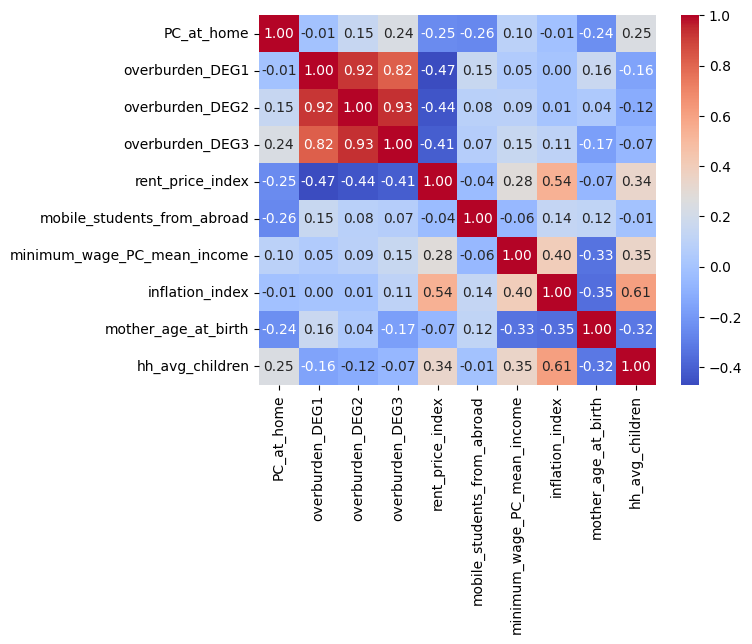

In [315]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_loaded.corr()
# Create a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

#### Conclusion
Only very weak correlations with the target feature 'PC_at_home'.

Strongest positive correlation is hh_avg_children with 0.25.

Weak negative correlation with rent_price_index (-0.247552), mobile_students_from_abroad (-0.262311), and mother_age_at_birth (-0.239900).

'hh_avg_children' has a moderately high correlation coefficient of 0.61 with 'inflation_index'.  